In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import seaborn as sns
import mdst # my data science tools

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [4]:
bcm_train = mdst.Binary_confusion_matrix(y_train, predict_train)

bcm_train.display_metrics()
bcm_train.df

Accuracy = 0.7774140752864157
Sensitivity = 0.5428470254957507
Specificity = 0.9243566992014197
Precision = 0.8180362860192102
negative predictive value = 0.7634664712348845



,pred_true,pred_false
actual_true,1533,1291
actual_false,341,4167


In [5]:
bcm_test = mdst.Binary_confusion_matrix(y_test, predict_test)
bcm_test.display_metrics()
bcm_test.df

Accuracy = 0.7521472392638037
Sensitivity = 0.5129032258064516
Specificity = 0.899009900990099
Precision = 0.7571428571428571
negative predictive value = 0.7504132231404959



,pred_true,pred_false
actual_true,159,151
actual_false,51,454


In [6]:
cv = cross_val_score(clf,X, y, cv=10)
print('cross val mean: {}'.format(np.mean(cv)))
print('cross val std: {}'.format(np.std(cv)))
cv

cross val mean: 0.744335385712145
cross val std: 0.02122275987310253


array([ 0.7622549 ,  0.7120098 ,  0.71691176,  0.72760736,  0.77272727,
        0.76904177,  0.72727273,  0.74447174,  0.76412776,  0.74692875])

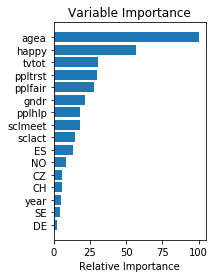

In [7]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [8]:
features = pd.DataFrame()
features['partner'] = df['partner']-1
features = pd.concat([features, df.drop('partner', axis=1)], axis=1)
features['year'] = features['year']-6
features = pd.concat([features, pd.get_dummies(df['cntry'])], axis=1)
features.drop(['cntry','idno'], axis=1, inplace=True)

# combine ppltrst, pplfair, pplhlp. Highly correlated with one another. 
means = features[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = features[['ppltrst','pplfair','pplhlp']].std(axis=0)
features['trust_fair_help'] = ((features[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)


# turn every survey answer into above average or below
columns = ['tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'trust_fair_help']
for col in columns:
    features[col+'binary'] = np.where(features[col]>np.mean(features[col]),1,0)

# make Nordic countries its own category
features['Nordic'] = np.where((df['cntry'].isin(['NO', 'SE'])), 1, 0)


nrml_happy = (features['happy'] - features['happy'].mean())/features['happy'].std()
nrml_tv = (features['tvtot'] - features['tvtot'].mean())/features['tvtot'].std()
features['happy/tv'] = nrml_happy/nrml_tv

features.head()

,partner,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,...,tvtotbinary,ppltrstbinary,pplfairbinary,pplhlpbinary,happybinary,sclmeetbinary,sclactbinary,trust_fair_helpbinary,Nordic,happy/tv
0,0.0,0,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,...,0,0,1,0,1,0,1,1,0,-0.415747
1,0.0,0,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,...,1,0,1,0,1,0,0,1,0,0.691175
2,1.0,0,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,...,0,1,1,1,0,1,1,1,0,0.293443
3,0.0,0,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,...,1,1,0,1,1,1,0,1,0,14.745951
4,0.0,0,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,...,1,1,1,0,1,1,0,1,0,0.288064


In [9]:
y = features['partner']
cols = ['year', 'happy', 'agea', 'tvtot',
       'sclmeet', 'sclact', 'gndr', 
       'trust_fair_help', 'Nordic']
X = features[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=3)

Previous Test Accuracy = 0.7521472392638037

Previous cross val mean: 0.744335385712145
Previous cross val std: 0.02122275987310253

In [10]:
params = {'n_estimators': 100,
          'max_depth': 3,
          'min_samples_leaf': 80,
          'subsample' : 1,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)


predict_test = clf.predict(X_test)

print('training data score: {}\n'.format(clf.score(X_train,y_train)))

bcm_test = mdst.Binary_confusion_matrix(y_test, predict_test)
bcm_test.display_metrics()
bcm_test.df
# a little better accuracy than before (about .25% better)

training data score: 0.772367703218767

Accuracy = 0.754601226993865
Sensitivity = 0.5272727272727272
Specificity = 0.9092783505154639
Precision = 0.7981651376146789
negative predictive value = 0.7386934673366834



,pred_true,pred_false
actual_true,174,156
actual_false,44,441


In [11]:
cv = cross_val_score(clf,X, y, cv=10)
print('cross val mean: {}'.format(np.mean(cv)))
print('cross val std: {}'.format(np.std(cv)))

cv

# cross validates better as well

cross val mean: 0.755367357408588
cross val std: 0.017128586666775605


array([ 0.76348039,  0.76838235,  0.76102941,  0.72392638,  0.76904177,
        0.77027027,  0.72235872,  0.75675676,  0.76781327,  0.75061425])

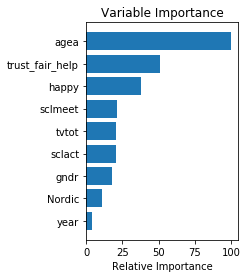

In [12]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()